<a href="https://colab.research.google.com/github/allenphos/ML-course/blob/main/Copy_of_HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантаження даних `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0)



В цьому змаганні будемо передбачати відтік клієнтів банку: чи продовжить клієнт користуватися своїм рахунком, чи закриє його

## Imports

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score

In [115]:
!pip install opendatasets --upgrade --quiet

In [116]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu"

od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


In [117]:
import os

data_dir = './bank-customer-churn-prediction-dlu'

os.listdir(data_dir)

['train.csv', 'sample_submission.csv', 'test.csv']

In [118]:
train_csv = data_dir + '/train.csv'

1. Зчитування даних `train.csv` в pandas dataframe та розбиття їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [119]:
raw_df = pd.read_csv(train_csv)

In [120]:
raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [121]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [122]:
# Splitting data into training, validating and testing sets

train_val_df, test_df = train_test_split(raw_df, test_size=0.2, stratify=raw_df['Exited'], random_state=42) # both the training and testing sets have the same proportion of samples for each class as the original dataset
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['Exited'], random_state=42)

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (9000, 14)
val_df.shape : (3000, 14)
test_df.shape : (3000, 14)


2. Визначаємо назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створення набору даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [123]:
input_cols = list(train_df.columns)[3:-1] # Removing columns that don't make sense for the model: 'id', 'Surname' and target
target_col = 'Exited'

print(input_cols)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [124]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

print('train_inputs.shape :', train_inputs.shape)
print('val_inputs.shape :', val_inputs.shape)

train_inputs.shape : (9000, 10)
val_inputs.shape : (3000, 10)


3. Визначення з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Записування результатів в `numeric_cols` та `categorical_cols` відповідно.

In [125]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist() # filters the DataFrame, selecting only the columns that contain numerical data types
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [126]:
numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [127]:
raw_df[numeric_cols].isna().sum()

,0
CreditScore,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [128]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00
mean,658.58,37.68,5.02,43029.89,1.59,0.79,0.49,117966.92
std,72.00,8.12,2.78,59826.88,0.53,0.41,0.50,45719.05
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83092.52
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123542.16
75%,708.00,42.00,7.00,109735.03,2.00,1.00,1.00,157097.09
max,850.00,72.00,10.00,209767.31,4.00,1.00,1.00,199992.48


To check if columns Balance has outliers I used Interquartile range (IQR)

In [129]:
Q1 = train_inputs['Balance'].quantile(0.25)
Q3 = train_inputs['Balance'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

109735.0325


In [130]:
Min_value = (Q1 - 1.5 * IQR)
Max_value = (Q3 + 1.5 * IQR)
print("Мінімальне значення, до якого існують викиди: {}".format(Min_value))
print("Максимальне значення, після якого існують викиди: {}".format(Max_value))

Мінімальне значення, до якого існують викиди: -164602.54875000002
Максимальне значення, після якого існують викиди: 274337.58125000005


In [131]:
import warnings

def dist_box(dataset, column):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")

      plt.figure(figsize=(16,6))

      plt.subplot(1,2,1)
      sns.distplot(dataset[column], color = 'purple')
      pltname = 'Графік розподілу для ' + column
      plt.ticklabel_format(style='plain', axis='x')
      plt.title(pltname)

      plt.subplot(1,2,2)
      red_diamond = dict(markerfacecolor='r', marker='D')
      sns.boxplot(y = column, data = dataset, flierprops = red_diamond)
      pltname = 'Боксплот для ' + column
      plt.title(pltname)

      plt.show()

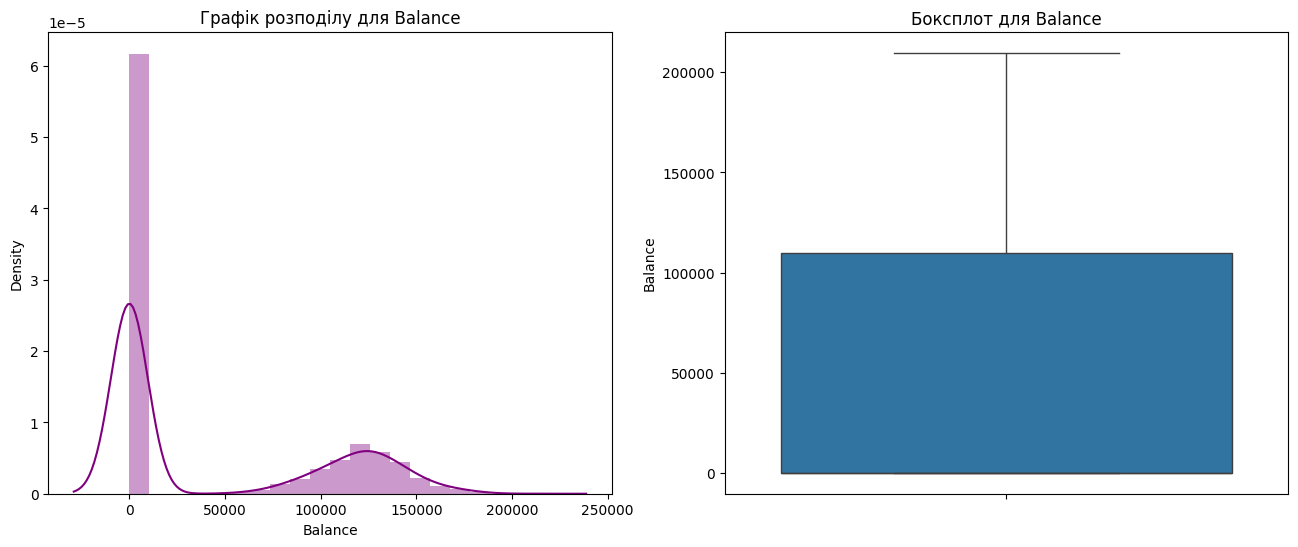

In [132]:
dist_box(train_inputs, 'Balance')

По графіку можно побачити, що аутлаєрів немає, але дані сильно розкидані. Треба масштабувати дані, щоб вони були в одному діапазоні та не було домінуючих колонок. Для логістичної регресії краще використовувати StandardScaler.

## Масштабування числових ознак
Масштабування числових ознак забезпечує, що жодна конкретна ознака не має непропорційного впливу на втрати моделі. Оптимізаційні алгоритми також працюють краще на практиці з меншими числами.

In [133]:
scaler = StandardScaler()
scaler.fit(train_inputs[numeric_cols])

StandardScaler()

In [134]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [135]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00
mean,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.16,-2.42,-1.81,-0.72,-1.11,-1.94,-0.98,-2.58
25%,-0.77,-0.70,-0.73,-0.72,-1.11,0.51,-0.98,-0.76
50%,0.03,-0.08,-0.01,-0.72,0.77,0.51,-0.98,0.12
75%,0.69,0.53,0.71,1.12,0.77,0.51,1.02,0.86
max,2.66,4.23,1.79,2.79,4.52,0.51,1.02,1.79


## Кодування категоріальних даних

In [136]:
train_inputs[categorical_cols].nunique()

,0
Geography,3
Gender,2


Для колонки Gender та Geography можна використати OneHotEncoder, бо він використовується для кодування категорій, які не мають порядку.

In [137]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoder.fit(train_inputs[categorical_cols])

encoded_cols = list(encoder.get_feature_names_out(categorical_cols)) # Generate column names for each individual category
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [138]:
encoder.transform(train_inputs[categorical_cols])

array([[1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.]])

In [139]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [140]:
train_inputs = train_inputs[numeric_cols + encoded_cols]
val_inputs = val_inputs[numeric_cols + encoded_cols]

In [141]:
# Displaying the transformed datasets
pd.set_option('display.max_columns', None)
display(train_inputs.head()), display(val_inputs.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
63,1.172656,-0.206530,-0.006364,-0.719280,0.770093,-1.942165,1.019751,-0.614074,1.0,0.0,0.0,0.0,1.0
13717,-0.716375,-0.329644,0.353839,-0.719280,0.770093,0.514889,1.019751,0.760490,1.0,0.0,0.0,0.0,1.0
13292,1.617134,-0.575872,0.353839,1.309285,-1.105641,0.514889,-0.980632,0.507155,1.0,0.0,0.0,1.0,0.0
9615,-1.008063,1.270836,-1.447176,-0.719280,-1.105641,-1.942165,1.019751,0.699518,0.0,0.0,1.0,0.0,1.0
1618,0.714288,-0.698986,-0.006364,-0.719280,0.770093,0.514889,-0.980632,-1.084221,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
4434,-1.383091,0.285925,0.714042,1.514424,-1.105641,-1.942165,1.019751,1.457127,1.0,0.0,0.0,0.0,1.0
8707,1.158766,-0.452758,0.714042,-0.719280,0.770093,-1.942165,1.019751,1.057622,1.0,0.0,0.0,0.0,1.0
679,1.589354,-0.452758,0.714042,-0.719280,0.770093,0.514889,-0.980632,-0.524183,1.0,0.0,0.0,0.0,1.0
4765,-0.827494,0.162811,-0.366567,-0.719280,0.770093,0.514889,1.019751,0.193142,1.0,0.0,0.0,0.0,1.0
9354,0.658728,0.162811,1.434448,0.947519,0.770093,0.514889,1.019751,0.272059,0.0,1.0,0.0,1.0,0.0


(None, None)

In [142]:
# Removing original columns
#train_inputs = train_inputs.drop(['Geography', 'Gender'], axis=1)
#val_inputs = val_inputs.drop(['Geography', 'Gender'], axis=1)

In [143]:
train_inputs

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
63,1.172656,-0.206530,-0.006364,-0.719280,0.770093,-1.942165,1.019751,-0.614074,1.0,0.0,0.0,0.0,1.0
13717,-0.716375,-0.329644,0.353839,-0.719280,0.770093,0.514889,1.019751,0.760490,1.0,0.0,0.0,0.0,1.0
13292,1.617134,-0.575872,0.353839,1.309285,-1.105641,0.514889,-0.980632,0.507155,1.0,0.0,0.0,1.0,0.0
9615,-1.008063,1.270836,-1.447176,-0.719280,-1.105641,-1.942165,1.019751,0.699518,0.0,0.0,1.0,0.0,1.0
1618,0.714288,-0.698986,-0.006364,-0.719280,0.770093,0.514889,-0.980632,-1.084221,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,-0.174667,-1.068327,-0.726770,-0.719280,0.770093,-1.942165,-0.980632,0.502544,1.0,0.0,0.0,0.0,1.0
12903,0.769848,0.655267,-0.006364,1.249931,-1.105641,-1.942165,-0.980632,0.730206,0.0,0.0,1.0,1.0,0.0
9131,0.478159,-0.452758,-1.447176,-0.719280,0.770093,0.514889,-0.980632,-0.489615,1.0,0.0,0.0,1.0,0.0
7057,0.839298,-1.068327,0.714042,0.424625,-1.105641,-1.942165,-0.980632,-0.632561,1.0,0.0,0.0,1.0,0.0


5. Збереження даних, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`.

In [144]:
!pip install pyarrow --quiet

In [145]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

pd.DataFrame(train_targets).to_parquet('train_targets.parquet') # 'Series' 'to_parquet'
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

In [146]:
!ls

bank-customer-churn-prediction-dlu  train_inputs.parquet   val_targets.parquet
log_reg.joblib			    train_targets.parquet
sample_data			    val_inputs.parquet


## Навчання моделі бінарної класифікації

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [147]:
X_train = pd.read_parquet('train_inputs.parquet')
X_val = pd.read_parquet('val_inputs.parquet')

y_train = pd.read_parquet('train_targets.parquet')
y_val = pd.read_parquet('val_targets.parquet')

In [148]:
model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(solver='liblinear')

In [149]:
model.coef_

array([[-0.15342215,  1.3244601 , -0.01824133, -0.3269059 , -0.70263223,
        -0.06818438, -0.64363913,  0.08061725, -0.81414387,  0.82321897,
        -1.00390933, -0.06566233, -0.92917189]])

In [150]:
model.intercept_

array([-0.99483422])

In [151]:
train_preds = model.predict(X_train)

In [152]:
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [153]:
train_targets

,Exited
63,0.0
13717,0.0
13292,0.0
9615,1.0
1618,0.0
...,...
1992,0.0
12903,1.0
9131,0.0
7057,0.0


Виводимо ймовірнісний прогноз за допомогою predict_proba

In [154]:
train_probs = model.predict_proba(X_train) # returns an array of probabilities for each class
train_probs # Example: 80% chance of not churning, 20% chance of churning

array([[0.98322375, 0.01677625],
       [0.98214408, 0.01785592],
       [0.87058278, 0.12941722],
       ...,
       [0.90641466, 0.09358534],
       [0.88901701, 0.11098299],
       [0.86302115, 0.13697885]])

In [155]:
np.argmax(train_probs, axis=1) # This function finds the index (position) of the maximum value within a given array.

array([0, 0, 0, ..., 0, 0, 0])

(array([4860., 1380.,  641.,  451.,  355.,  303.,  230.,  220.,  290.,
         270.]),
 array([0.00110373, 0.1004832 , 0.19986266, 0.29924213, 0.3986216 ,
        0.49800107, 0.59738054, 0.69676001, 0.79613948, 0.89551894,
        0.99489841]),
 <BarContainer object of 10 artists>)

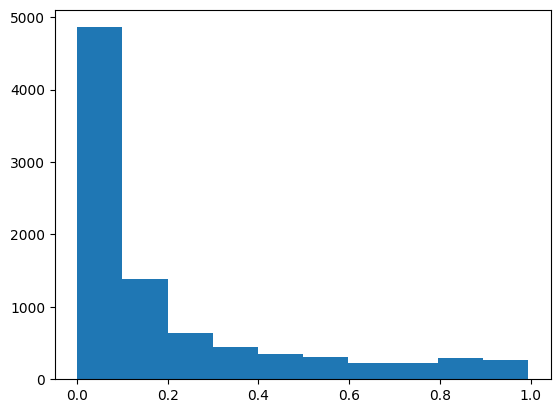

In [156]:
plt.hist(train_probs[:,1]) # histogram to visualize the distribution of probabilities for customers churning
# 1 This array represents the frequencies (counts) of data points within each bin of the histogram ( approximately 4860 data points in the first bin)
# 2 This array represents the edges of the bins in the histogram

In [157]:
(train_probs[:,1][:20]>0.2).astype(int) #  ,1 predicted probabilities of the positive class

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [158]:
train_probs[:,1].round(2)[:20] # all the rows (:) from the second column (1)

array([0.02, 0.02, 0.13, 0.37, 0.03, 0.02, 0.02, 0.39, 0.47, 0.03, 0.12,
       0.04, 0.05, 0.05, 0.03, 0.13, 0.03, 0.54, 0.47, 0.09])

In [159]:
train_targets.value_counts(normalize=True)

,proportion
Exited,
0.0,0.796556
1.0,0.203444


In [160]:
model.classes_

array([0., 1.])

## Визначення якості моделі

7. Виведення Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можна сказати про якіст моделі? Вона хороша, погана, задовільна?

In [161]:
accuracy_score(train_targets, train_preds)

0.8737777777777778

In [162]:
confusion_matrix(train_targets, train_preds)

array([[6866,  303],
       [ 833,  998]])

Функція для генерації прогнозів, обчислення точності та побудови матриці невідповідностей для заданого набору вхідних даних

In [163]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.38%


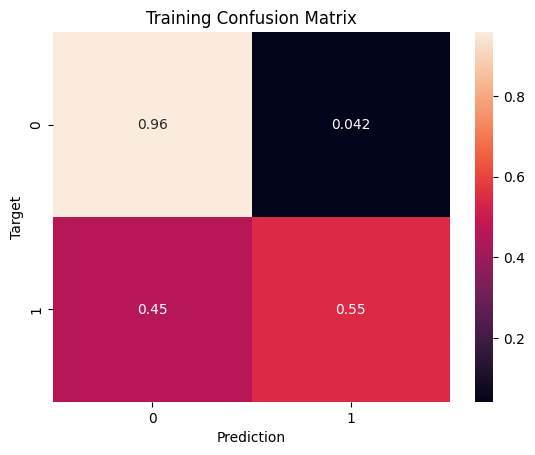

In [164]:
train_preds = predict_and_plot(X_train, y_train, 'Training')

Accuracy: 87.27%


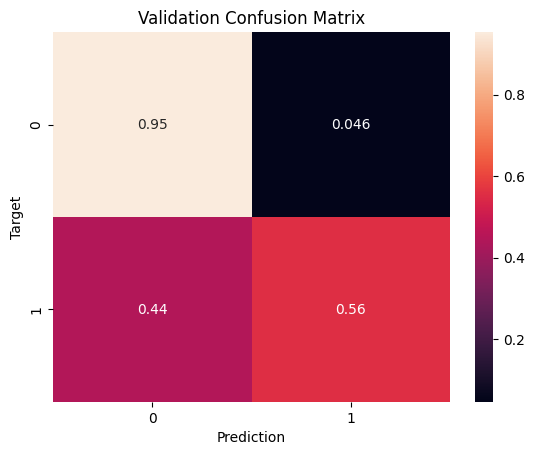

In [165]:
val_preds = predict_and_plot(X_val, y_val, 'Validation')

How to Interpret the Confusion Matrix

Diagonal Elements (TP and TN): The values along the main diagonal represent correct predictions. Larger values here indicate better performance.
Off-Diagonal Elements (FP and FN): The values off the diagonal represent incorrect predictions. Smaller values here are desirable.

Точність моделі на валідаційному наборі перевищує 87%, що свідчить про те, що модель добре узагальнює дані, які вона раніше не бачила.

## F1 Score для порога класифікації 0.5

F1 метрика розраховується як гармонічне середнє між Precision та Recall

In [166]:
preds = model.predict(X_train)
preds[:5], y_train[:5]

(array([0., 0., 0., 0., 0.]),
        Exited
 63        0.0
 13717     0.0
 13292     0.0
 9615      1.0
 1618      0.0)

In [167]:
f1_score(y_train, preds, pos_label=1) #  By default, LogisticRegression uses a threshold of 0.5 to convert probabilities into class labels (0 or 1).

0.6372924648786717

In [168]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, y_train, 'Training')
get_f1_score(X_val, y_val, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


The F1 score is a metric used to evaluate the performance of a binary classification model. It's calculated as the harmonic mean of precision and recall:

Precision: The proportion of correctly predicted positive instances out of all instances predicted as positive.
Recall: The proportion of correctly predicted positive instances out of all actual positive instances.

Model has a reasonable balance between precision and recall, and correctly identifying a decent portion of the positive class (customer churn) while not having too many false positives

## Побудова ROC Curve та обчислення AUROC для моделі

In [169]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


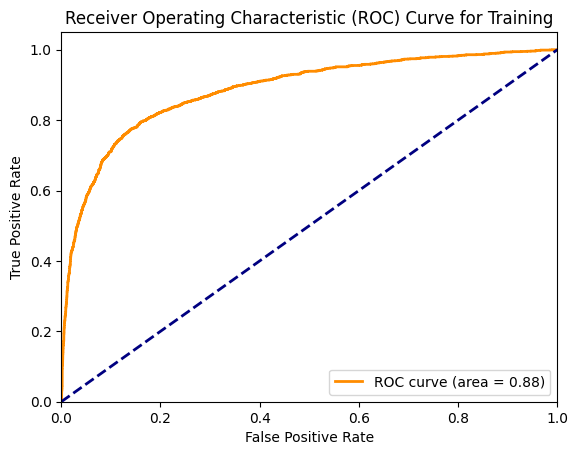

AUROC for Validation: 0.88


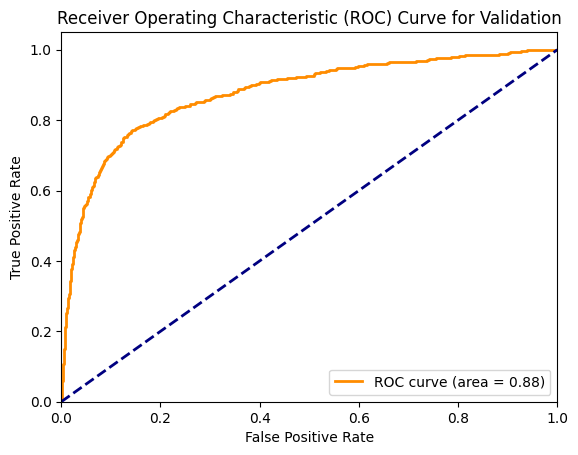

In [170]:
compute_auroc_and_build_roc(X_train, y_train, 'Training')
compute_auroc_and_build_roc(X_val, y_val, 'Validation')

Значення F1 Score 64% та AUROC 88% досить високі, що свідчить, що модель добре навчилась розрізняти поміж негативними та позитивними класами. ROC крива наближена до TPR, a Confusion Matrix та точніть мають хороші показники.

How to Interpret the ROC Curve

Shape:
A curve that is closer to the top-left corner of the plot indicates a better-performing model. This means the model has a higher TPR and a lower FPR.
A curve that is closer to the diagonal line represents a model with performance similar to random guessing.
Area Under the Curve (AUROC):
The AUROC (Area Under the ROC Curve) is a single numerical value that summarizes the model's overall performance. A higher AUROC indicates a better model.
An AUROC of 0.5 represents a random classifier.
An AUROC of 1 represents a perfect classifier.
Threshold Selection:
Different points on the ROC curve correspond to different classification thresholds. By examining the curve, you can choose a threshold that balances the desired trade-off between TPR and FPR.

8. Створення передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

Щоб перевірити, чи дійсно модель чомусь навчилась можна порівняти її з результати з "негативною" моделлю, яка завжди повертає "Ні" або 0.

In [171]:
def all_no(inputs):
    return np.full(len(inputs), 0)

print('Accuracy score for negative class on train set', accuracy_score(y_train, all_no(X_train)))
print('Accuracy score for negative class on validation set', accuracy_score(y_val, all_no(X_val)))

Accuracy score for negative class on train set 0.7965555555555556
Accuracy score for negative class on validation set 0.7963333333333333


Тривіальна  модель, яка завжди передбачає негативний клас (відсутність відтоку клієнтів), демонструє точність 80%. Це свідчить про те, що метрика Accuracy може бути оманливою в даному випадку, оскільки більшість клієнтів дійсно не відмовляються від послуг банку. Таким чином, висока точність тривіальної моделі не гарантує її ефективності.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [172]:
import joblib

In [173]:
churn_prediction = {
    'model': model,
    #'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [174]:
joblib.dump(churn_prediction, 'log_reg.joblib') # save file

['log_reg.joblib']

In [175]:
churn_prediction2 = joblib.load('log_reg.joblib')

In [176]:
model_2 = churn_prediction2['model'].predict(X_val)
accuracy_score(y_val, model_2)

0.8726666666666667

10. `predict_raw_df` функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.


In [183]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [184]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.0060288 , 0.03124995, 0.41407866, 0.40944352, 0.98178409])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [185]:
test_raw_df = pd.read_csv(data_dir + '/test.csv')

test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

test_raw_df['Exited']

,Exited
0,0.070364
1,0.032937
2,0.163502
3,0.191805
4,0.052659
...,...
9995,0.018266
9996,0.023340
9997,0.015194
9998,0.151207


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [186]:
sample_submission = pd.read_csv(data_dir + '/sample_submission.csv')

sample_submission['Exited'] = test_raw_df['Exited']

sample_submission

,id,Exited
0,15000,0.070364
1,15001,0.032937
2,15002,0.163502
3,15003,0.191805
4,15004,0.052659
...,...,...
9995,24995,0.018266
9996,24996,0.023340
9997,24997,0.015194
9998,24998,0.151207


In [181]:
sample_submission['Exited'].to_csv('submission_log_reg.csv', index=False)